In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
#création de la donnée train
train=pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')
modeleresultat=pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
print(train.columns)
print(modeleresultat.head())
print("salut")
print(test.columns)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
salut
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


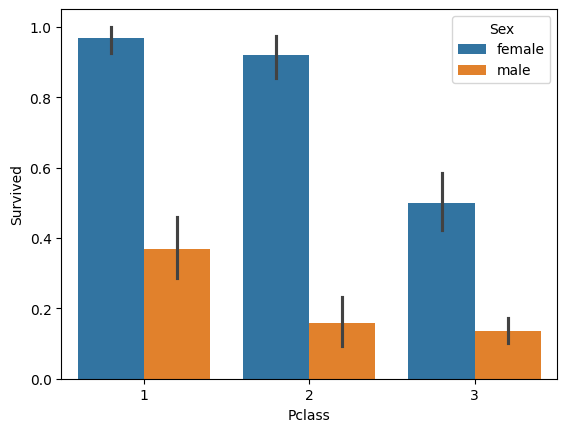

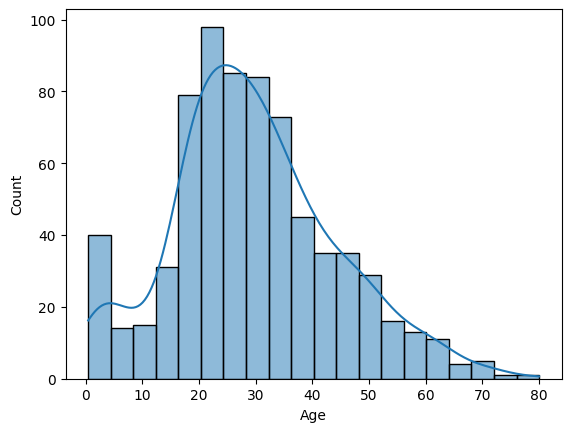

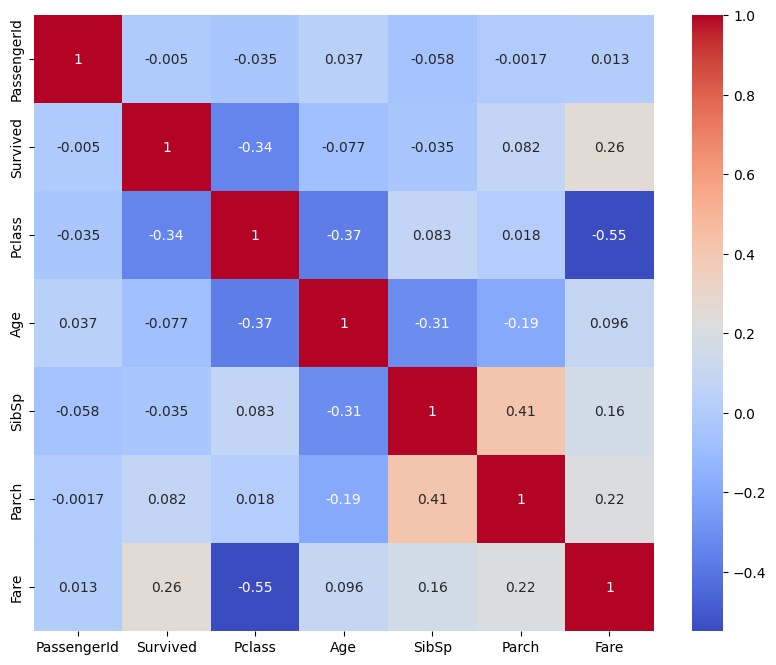

Heatmap de la correlation


In [2]:
#Création de graphique afin de mieux comprendre le problème et le correlation.
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train)#plus de femme que d'homme en proportion "Les femmes et les enfants d'abord !"
plt.show()
#342 survivant
sns.histplot(train['Age'].dropna(), kde=True)
plt.show
#heatmap de la correlation pour étudier profondement le problème
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()
print('Heatmap de la correlation')

In [3]:
#On nettoie les données pour gagner de la précision
#première version du nettoyage on enleve tous les NaN et Cabin car vide à 75%.
pd.set_option('future.no_silent_downcasting', True)
print("Nombre de NaN par colonne :")
print(train.isnull().sum())
train2=train.drop(columns=['Cabin','Ticket','Name'])
train2['Age'] = train2['Age'].fillna(train2['Age'].median()) #on met la mediane au gens qui n'ont pas renseigné leur age.

train2['Sex']=train2['Sex'].replace(['female','male'],[0,1]).infer_objects(copy=False) #Homme femme devient 1 0 

embarked_dummies = pd.get_dummies(train2['Embarked'], prefix='Embarked',dtype=int)#l'embarquement devient 3 colonnes de 0 ou de 1 (différenciation de lieu initial, correlation avec l'argent)
train2 = pd.concat([train2, embarked_dummies], axis=1)
train2 = train2.drop('Embarked', axis=1)

print(train2.columns)
#preparation de test
test['Sex'] = test['Sex'].replace(['female', 'male'], [0, 1]).infer_objects(copy=False)
test['Age'] = test['Age'].fillna(train2['Age'].median())
test['Fare'] = test['Fare'].fillna(train2['Fare'].median())
test_dummies = pd.get_dummies(test['Embarked'], prefix='Embarked',dtype=int)
test = pd.concat([test, test_dummies], axis=1)

features_model = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                  'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize']
# On utilise une expression régulière pour attraper le mot qui finit par un point
# --- ÉTAPE 1 : Extraction et Nettoyage des Titres ---
# On extrait les titres pour les deux datasets
train2['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# On regroupe pour éviter d'avoir trop de colonnes (Réduction du bruit)
def simplify_titles(df):
    # On garde les 4 principaux et on groupe le reste en "Rare"
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    rare_titles = ['Rev', 'Dr', 'Col', 'Major', 'Don', 'Lady', 'Sir', 'Capt', 'Countess', 'Jonkheer', 'Dona']
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    return df

train2 = simplify_titles(train2)
test = simplify_titles(test)

# --- ÉTAPE 2 : Encodage (One-Hot) ---
# On crée les colonnes Title_Mr, Title_Miss, etc.
train_title_dummies = pd.get_dummies(train2['Title'], prefix='Title', dtype=int)
train2 = pd.concat([train2, train_title_dummies], axis=1)

test_title_dummies = pd.get_dummies(test['Title'], prefix='Title', dtype=int)
test = pd.concat([test, test_title_dummies], axis=1)

# --- ÉTAPE 3 : Famille ---
train2['FamilySize'] = train2['SibSp'] + train2['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

# --- ÉTAPE 4 : Liste des Features finale ---
# On ajoute les nouvelles colonnes Title_... à notre liste
features_model = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                  'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize',
                  'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']

# Vérification : on s'assure que toutes ces colonnes existent dans le test
# (Si un titre manque dans le test, on crée la colonne remplie de 0)
for col in features_model:
    if col not in test.columns:
        test[col] = 0


print(f"Nombre de lignes avant : {len(train)}")
print(f"Nombre de lignes après les filtres : {len(train2)}")

Nombre de NaN par colonne :
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')
Nombre de lignes avant : 891
Nombre de lignes après les filtres : 891


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import numpy as np

# --- ÉTAPE 1 : Définition des variables ---

X = train2[features_model]
y = train2['Survived']
X_test_kaggle = test[features_model]

# --- ÉTAPE 2 : La Validation Locale (Split) ---
# On coupe train2 : 80% pour que randomf apprenne, 20% pour le tester nous-mêmes
X_train_local, X_val, y_train_local, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- ÉTAPE 3 : Création et Entraînement du modèle (randomf) ---
# max_depth=5 : On limite la profondeur pour éviter le "par cœur" (overfitting)
randomf = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=42)

# Le modèle apprend sur 80% des données
randomf.fit(X_train_local, y_train_local)

# --- ÉTAPE 4 : Évaluation Locale ---
# On demande au modèle de passer l'examen blanc sur les 20% restants
val_predictions = randomf.predict(X_val)
score = accuracy_score(y_val, val_predictions)

print(f"Ton score de validation locale (Accuracy) : {score*100:.2f}%")
print("C'est ce score qui te dit si ton modèle est 'intelligent'.")

scores = cross_val_score(randomf, X, y, cv=5)

print(f"Scores des 5 essais : {scores}")
print(f"Score moyen (le 'vrai' score) : {scores.mean()*100:.2f}%")
print(f"Écart-type (stabilité) : {scores.std()*100:.2f}%")

# --- ÉTAPE 5 : Entraînement Final & Prédiction Kaggle ---
# Maintenant qu'on sait que le modèle est bon, on le ré-entraîne sur 100% des données train2
# pour qu'il soit le plus musclé possible avant l'examen final
randomf.fit(X, y)


# Le grand saut : Prédiction finale
final_predictions = randomf.predict(X_test_kaggle)

# --- ÉTAPE 6 : Création du fichier de soumission ---
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"], # Ici on a besoin de l'ID pour que Kaggle reconnaisse le passager
    "Survived": final_predictions
})

# On enlève l'index pour respecter le format Kaggle
submission.to_csv('submission.csv', index=False)

print("Fichier 'submission.csv' généré avec succès ! Tu peux le soumettre sur Kaggle.")

Ton score de validation locale (Accuracy) : 82.68%
C'est ce score qui te dit si ton modèle est 'intelligent'.
Scores des 5 essais : [0.8547486  0.82022472 0.8258427  0.79775281 0.85393258]
Score moyen (le 'vrai' score) : 83.05%
Écart-type (stabilité) : 2.16%
Fichier 'submission.csv' généré avec succès ! Tu peux le soumettre sur Kaggle.


In [5]:
from sklearn.model_selection import GridSearchCV

# 1. On définit la grille de paramètres
# On teste autour de max_depth=5 car c'est là que tu as de bons résultats
param_grid = {
    'n_estimators': [150],
    'max_depth': [ 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2,],
    'max_features': ['sqrt', None]
}

# 2. Création du GridSearch
# n_jobs=-1 utilise toute la puissance de ton processeur
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1 # Pour voir l'avancée du calcul
)

# 3. Entraînement sur TOUTES les données d'entraînement
grid_search.fit(X, y)

# 4. Affichage des résultats
print(f"Meilleur score de Cross-Val : {grid_search.best_score_*100:.2f}%")
print(f"Meilleurs paramètres : {grid_search.best_params_}")

# 5. Utilisation du meilleur modèle pour la soumission
best_rf = grid_search.best_estimator_
final_predictions = best_rf.predict(X_test_kaggle)

# 6. Génération du fichier final
submission1 = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": final_predictions
})
submission1.to_csv('submission_optimized.csv', index=False)
print("Fichier 'submission_optimized.csv' prêt !")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleur score de Cross-Val : 84.96%
Meilleurs paramètres : {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Fichier 'submission_optimized.csv' prêt !
